# Create, train, and test the multi layer perceptron model

In [1]:
#install python libraries (optional)
!pip install --upgrade scikit-learn
!pip install pandas
!pip install pyyaml h5py 
!pip install seaborn

     |████████████████████████████████| 22.2 MB 982 kB/s eta 0:00:01
     |████████████████████████████████| 303 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.5 MB 831 kB/s eta 0:00:01
     |████████████████████████████████| 510 kB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 640 kB 617 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 285 kB 616 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import sklearn
from sklearn.metrics import auc, average_precision_score, roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


# other libraries
import numpy as np
import pandas as pd
import sys
import pickle

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

print('tensorflow-' + tf.__version__)
print('python-' + sys.version)
print('sklearn-' + sklearn.__version__)
print('numpy-' + np.__version__)
print('pandas-' + pd.__version__)

tensorflow-2.4.1
python-3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
sklearn-0.24.1
numpy-1.19.5
pandas-1.1.5


In [53]:
#load numeric column names for scaling
with open('numeric_columns.pickle', 'rb') as f:  
    nu_cols = pickle.load(f)
    
def onc_plot_cm(y_true, y_predictions, proba_threshold=0.5):
    '''
    Plot the confusion matrix
    '''
    cm = confusion_matrix(y_true, y_predictions > proba_threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(proba_threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Survival Detected (True Negatives): ', cm[0][0])
    print('Legitimate Survival Incorrectly Detected (False Positives): ', cm[0][1])
    print('Deceased Missed (False Negatives): ', cm[1][0])
    print('Deceased Detected (True Positives): ', cm[1][1])
    print('Total Deceased: ', np.sum(cm[1]))
    print('Total Survived: ', np.sum(cm[0]))
    plt.show()

def onc_plot_roc(train_y, train_predictions, test_y, test_predictions, **kwargs):
    '''
    Plot the training and test set roc curves and return the test ROC curve results
    '''
    train_false_positives, train_true_positives, _ = roc_curve(train_y, train_predictions)
    train_roc_auc_score = auc(train_false_positives, train_true_positives)

    test_false_positives, test_true_positives, _ = roc_curve(test_y, test_predictions)
    test_roc_auc_score = auc(test_false_positives, test_true_positives)
    
    plt.plot(
        100*train_false_positives, 100*train_true_positives, 
        label=r'Train ROC MLP model (AUC = %0.3f)' % (train_roc_auc_score), 
        linewidth=2, 
        linestyle='--'
    )
    plt.plot(
        100*test_false_positives, 100*test_true_positives, 
        label=r'Test ROC MLP model (AUC = %0.3f)' % (test_roc_auc_score), 
        linewidth=2,
        **kwargs)

    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    plt.grid(False)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.show()
    
    return(test_false_positives, test_true_positives, test_roc_auc_score)

def onc_plot_precision_recall(train_y, train_predictions, test_y, test_predictions, **kwargs):
    '''
    Plot the training and test set pr curves and return the test pr curve results
    '''
    train_precision, train_recall, _ = precision_recall_curve(train_y, train_predictions)
    train_ap_score = average_precision_score(train_y, train_predictions)
    
    test_precision, test_recall, _ = precision_recall_curve(test_y, test_predictions)
    test_ap_score = average_precision_score(test_y, test_predictions)
    
    
    plt.plot(
         100*train_recall,100*(1-train_precision),
        label=r'Train Precision-Recall Curve MLP model (AUC = %0.3f)' % (train_ap_score), 
        linewidth=2, 
        linestyle='--'
    )
    plt.plot(
        100*test_recall, 100*(1-test_precision),
        label=r'Test Precision-Recall Curve MLP model (AUC = %0.3f)' % (test_ap_score), 
        linewidth=2,
        **kwargs)

    plt.ylabel('Precision (PPV) [%]')
    plt.xlabel('Recall (Sensitivity) [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    plt.grid(False)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.show()
    
    return(test_precision, test_recall, test_ap_score)

# final model

In [54]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='auc_pr',
            num_thresholds=200,
            curve="PR",
            summation_method="interpolation",
            dtype=None,
            thresholds=None,
            multi_label=False,
            label_weights=None)
]

# put in the best hyperparameters from the cross validation tuning
def final_build_mlp(
    layers=2,
    neurons=16,
    output_bias=None, 
    optimizer='Adam',
    activation='relu',
    learn_rate=.0002,
    dropout_rate=0.2,
    kernel_regularizer='l2',
    metrics=METRICS
):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = tf.keras.Sequential()
    
    #add one or more dense layers
    for i in range(layers):
        model.add(Dense(
                        neurons, 
                        activation=activation,
                        input_shape=(294,),
                        kernel_regularizer=kernel_regularizer)
        )                       
    model.add(Dropout(dropout_rate))
    model.add(Dense(
                     1, 
                     activation='sigmoid',
                     bias_initializer=output_bias))
    opt = Adam(lr=learn_rate)
    model.compile(
      optimizer=opt,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [55]:
def get_data(imp):
    with open('complete' + str(imp) + '.pickle', 'rb') as f:
        dataset = pickle.load(f)
    
    ##Training set = subsets 0-6
    X_train =  dataset[dataset.subset <= 4].copy().sort_values(by = 'usrds_id')
    y_train = np.array(X_train.pop('died_in_90'))

    ##validation set = subsets 5-6
    X_val = dataset[(dataset.subset == 6) | (dataset.subset == 5)].copy().sort_values(by = 'usrds_id')
    y_val = np.array(X_val.pop('died_in_90'))
    print('shape val ' + str(X_val.shape))
    
    # test set = subsets 7 8 9
    # sorting by usrds_id is important so that we can calculate the fairness (or you could just run the predictions again.)
    X_test =  dataset[dataset.subset > 6].copy().sort_values(by = 'usrds_id')
    y_test = np.array(X_test.pop('died_in_90'))
    
    # scale the numeric features by fitting on the training set 
    scaler = StandardScaler()
    X_train[nu_cols] = scaler.fit_transform(X_train[nu_cols])
    X_train = np.array(X_train.drop(columns=['subset','usrds_id','impnum'])) 
    print('scaled shape train ' + str(X_train.shape))

    # use the model from scaling on the training data to transform val and test sets
    X_val[nu_cols] = scaler.transform(X_val[nu_cols])
    X_val = np.array(X_val.drop(columns=['subset','usrds_id','impnum'])) 
    print('scaled shape val ' + str(X_val.shape))
    
    X_test[nu_cols] = scaler.transform(X_test[nu_cols])
    X_test = np.array(X_test.drop(columns=['subset','usrds_id','impnum'])) 
    print('scaled shape test ' + str(X_test.shape))
    
    return(X_train, y_train, X_val, y_val, X_test, y_test)

# Train model and test

shape val (230143, 297)
scaled shape train (574747, 294)
scaled shape val (230143, 294)
scaled shape test (345305, 294)
Epoch 1/10
2246/2246 [==============================] - 8s 3ms/step - loss: 1.4851 - tp: 9643.9599 - fp: 42908.6929 - tn: 223251.2755 - fn: 11939.7539 - accuracy: 0.8277 - precision: 0.1850 - recall: 0.3727 - auc: 0.6961 - auc_pr: 0.1701 - val_loss: 0.6039 - val_tp: 11071.0000 - val_fp: 42236.0000 - val_tn: 170508.0000 - val_fn: 6328.0000 - val_accuracy: 0.7890 - val_precision: 0.2077 - val_recall: 0.6363 - val_auc: 0.8032 - val_auc_pr: 0.2514
Epoch 2/10
2246/2246 [==============================] - 4s 2ms/step - loss: 1.0413 - tp: 13500.2790 - fp: 56064.2234 - tn: 210110.4855 - fn: 8068.6943 - accuracy: 0.7776 - precision: 0.1948 - recall: 0.6232 - auc: 0.7907 - auc_pr: 0.2281 - val_loss: 0.5196 - val_tp: 11766.0000 - val_fp: 47303.0000 - val_tn: 165441.0000 - val_fn: 5633.0000 - val_accuracy: 0.7700 - val_precision: 0.1992 - val_recall: 0.6762 - val_auc: 0.8077 - val

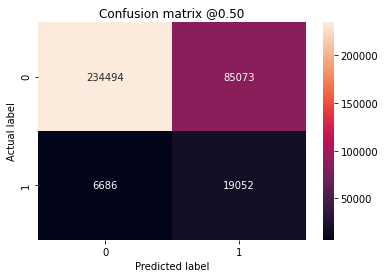

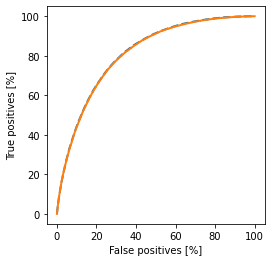

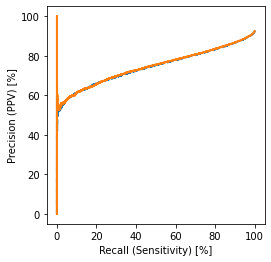

shape val (230143, 297)
scaled shape train (574747, 294)
scaled shape val (230143, 294)
scaled shape test (345305, 294)
Epoch 1/10
2246/2246 [==============================] - 7s 3ms/step - loss: 1.4342 - tp: 35157.7966 - fp: 190930.2764 - tn: 394866.4593 - fn: 12094.1500 - accuracy: 0.6797 - precision: 0.1559 - recall: 0.7450 - auc: 0.7756 - auc_pr: 0.1971 - val_loss: 0.6550 - val_tp: 12961.0000 - val_fp: 59848.0000 - val_tn: 152896.0000 - val_fn: 4438.0000 - val_accuracy: 0.7207 - val_precision: 0.1780 - val_recall: 0.7449 - val_auc: 0.8027 - val_auc_pr: 0.2456
Epoch 2/10
2246/2246 [==============================] - 5s 2ms/step - loss: 1.0258 - tp: 15649.8794 - fp: 73454.5915 - tn: 192790.1019 - fn: 5849.1095 - accuracy: 0.7222 - precision: 0.1743 - recall: 0.7299 - auc: 0.7970 - auc_pr: 0.2345 - val_loss: 0.5533 - val_tp: 12519.0000 - val_fp: 54246.0000 - val_tn: 158498.0000 - val_fn: 4880.0000 - val_accuracy: 0.7431 - val_precision: 0.1875 - val_recall: 0.7195 - val_auc: 0.8069 - v

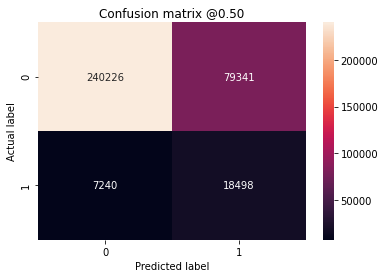

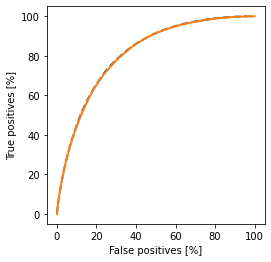

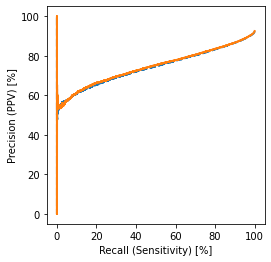

shape val (230143, 297)
scaled shape train (574747, 294)
scaled shape val (230143, 294)
scaled shape test (345305, 294)
Epoch 1/10
2246/2246 [==============================] - 7s 3ms/step - loss: 1.3539 - tp: 33861.7125 - fp: 173489.9186 - tn: 412342.3298 - fn: 13354.7214 - accuracy: 0.7055 - precision: 0.1637 - recall: 0.7175 - auc: 0.7827 - auc_pr: 0.2240 - val_loss: 0.6002 - val_tp: 12431.0000 - val_fp: 54946.0000 - val_tn: 157798.0000 - val_fn: 4968.0000 - val_accuracy: 0.7397 - val_precision: 0.1845 - val_recall: 0.7145 - val_auc: 0.8017 - val_auc_pr: 0.2461
Epoch 2/10
2246/2246 [==============================] - 4s 2ms/step - loss: 0.9930 - tp: 15469.7664 - fp: 70157.3142 - tn: 196142.2069 - fn: 5974.3947 - accuracy: 0.7353 - precision: 0.1797 - recall: 0.7204 - auc: 0.7986 - auc_pr: 0.2336 - val_loss: 0.5232 - val_tp: 12331.0000 - val_fp: 52040.0000 - val_tn: 160704.0000 - val_fn: 5068.0000 - val_accuracy: 0.7519 - val_precision: 0.1916 - val_recall: 0.7087 - val_auc: 0.8084 - v

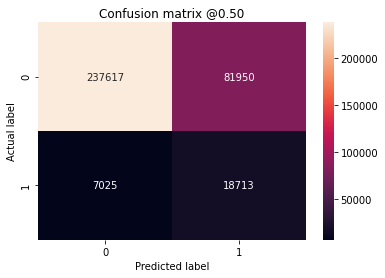

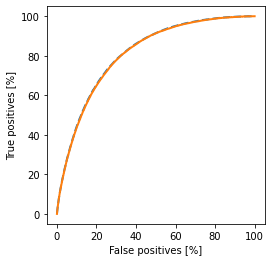

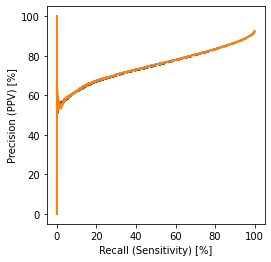

shape val (230143, 297)
scaled shape train (574747, 294)
scaled shape val (230143, 294)
scaled shape test (345305, 294)
Epoch 1/10
2246/2246 [==============================] - 7s 3ms/step - loss: 1.3776 - tp: 34115.3044 - fp: 176003.4206 - tn: 409824.1949 - fn: 13105.7623 - accuracy: 0.7024 - precision: 0.1630 - recall: 0.7222 - auc: 0.7820 - auc_pr: 0.2213 - val_loss: 0.6407 - val_tp: 12820.0000 - val_fp: 58629.0000 - val_tn: 154115.0000 - val_fn: 4579.0000 - val_accuracy: 0.7254 - val_precision: 0.1794 - val_recall: 0.7368 - val_auc: 0.8022 - val_auc_pr: 0.2474
Epoch 2/10
2246/2246 [==============================] - 4s 2ms/step - loss: 1.0168 - tp: 15719.7370 - fp: 72788.8923 - tn: 193430.1842 - fn: 5804.8687 - accuracy: 0.7250 - precision: 0.1768 - recall: 0.7331 - auc: 0.8005 - auc_pr: 0.2353 - val_loss: 0.5515 - val_tp: 12768.0000 - val_fp: 56427.0000 - val_tn: 156317.0000 - val_fn: 4631.0000 - val_accuracy: 0.7347 - val_precision: 0.1845 - val_recall: 0.7338 - val_auc: 0.8074 - v

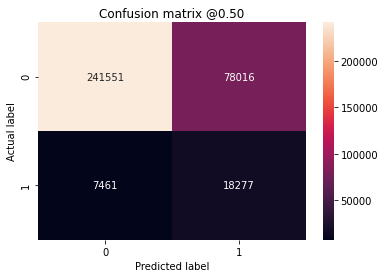

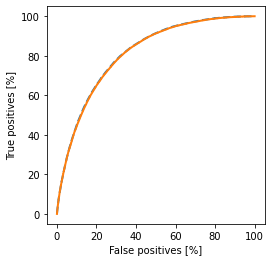

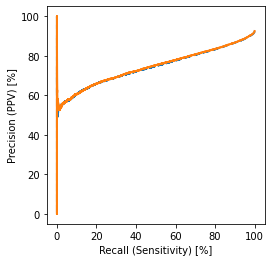

shape val (230143, 297)
scaled shape train (574747, 294)
scaled shape val (230143, 294)
scaled shape test (345305, 294)
Epoch 1/10
2246/2246 [==============================] - 7s 3ms/step - loss: 1.3834 - tp: 33451.3053 - fp: 171035.0988 - tn: 414834.6173 - fn: 13727.6609 - accuracy: 0.7085 - precision: 0.1639 - recall: 0.7096 - auc: 0.7815 - auc_pr: 0.2124 - val_loss: 0.6305 - val_tp: 12651.0000 - val_fp: 56573.0000 - val_tn: 156171.0000 - val_fn: 4748.0000 - val_accuracy: 0.7336 - val_precision: 0.1828 - val_recall: 0.7271 - val_auc: 0.8043 - val_auc_pr: 0.2522
Epoch 2/10
2246/2246 [==============================] - 4s 2ms/step - loss: 1.0107 - tp: 15519.3841 - fp: 69722.8919 - tn: 196490.0574 - fn: 6011.3489 - accuracy: 0.7366 - precision: 0.1812 - recall: 0.7186 - auc: 0.7988 - auc_pr: 0.2373 - val_loss: 0.5413 - val_tp: 12642.0000 - val_fp: 54863.0000 - val_tn: 157881.0000 - val_fn: 4757.0000 - val_accuracy: 0.7409 - val_precision: 0.1873 - val_recall: 0.7266 - val_auc: 0.8077 - v

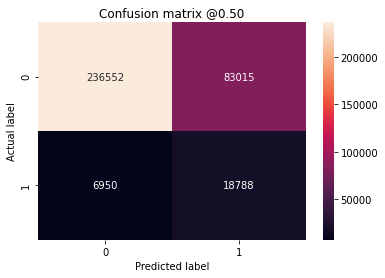

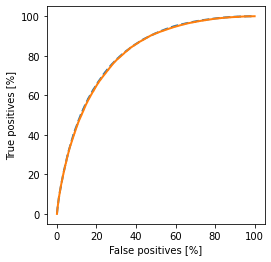

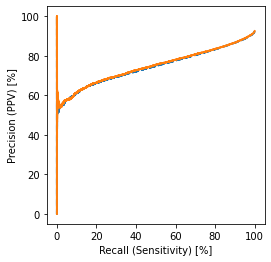

In [56]:
date_final = 2021
imp = 0
y_test_all = []
y_pred_proba_all = []
fpr_list=[]
tpr_list=[]
roc_auc_list=[]
seed = 78
np.random.seed(seed)

prec_list = []
rec_list = []
thresh_list = []
ap_score_list = []
    
#for each imputed set
for i  in range(5):
    imp = imp + 1
    
    X_train, y_train, X_val, y_val, X_test, y_test = get_data(imp)
    
    #optimal params for the .fit
    class_weight_10 = {0: 1, 1: 10}
    epochs_final = 10
    batches = 256
    
    #instantiate model defined above
    final_model = final_build_mlp()
    
    #train the final model on the train/validation sets
    final_history = final_model.fit(
        X_train,
        y_train,
        batch_size=batches,
        epochs=epochs_final,
        validation_data=(X_val, y_val),
        class_weight=class_weight_10)
    
    #results from training
    train_predictions_final = final_model.predict(
        X_train, 
        batch_size=batches
    )
    
    #test the model on new data (test set)
    test_predictions_final = final_model.predict(
        X_test, 
        batch_size=batches
    )
    final_eval = final_model.evaluate(
        X_test, 
        y_test,
        batch_size=batches, 
        verbose=1
    )
    
    #print results of test set
    res = {}
    for name, value in zip(final_model.metrics_names, final_eval):
        print(name, ': ', value)
        res = {name : value}
    
    #plot confusion matrix results
    onc_plot_cm(y_test, test_predictions_final)
    
    #plot roc auc results
    test_false_positives, test_true_positives, test_roc_auc_score = onc_plot_roc(
        y_train.ravel(), 
        train_predictions_final, 
        y_test.ravel(),
        test_predictions_final
    )
    #collect results of the test roc_curve for saving
    fpr_list.append(test_false_positives)
    tpr_list.append(test_true_positives)
    roc_auc_list.append(test_roc_auc_score)
    
    #collect results of the test precision recall curve for saving
    test_precision, test_recall, test_ap_score = onc_plot_precision_recall(
        y_train.ravel(), 
        train_predictions_final, 
        y_test.ravel(),
        test_predictions_final)
    
    prec_list.append(test_precision)
    rec_list.append(test_recall)
    ap_score_list.append(test_ap_score)
    
    #collect results
    y_test_all.append(y_test.ravel())
    y_pred_proba_all.append(test_predictions_final)
    
    #save dicts of results
    with open(str(date_final)+'_MLP_final_results_imp_' + str(imp) + '.pickle', 'wb') as f:  
        pickle.dump(res, f)

    # Save the entire model to a HDF5 file.
    # The '.h5' extension indicates that the model should be saved to HDF5.
    final_model.save(str(date_final)+'_MLP_final_model_imp_' + str(imp) + '.h5') 
        
    with open(str(date_final)+'_MLP_final_eval_imp_' + str(imp) + '.pickle','wb') as f:  
        pickle.dump(final_eval, f)

# save metrics from all imputations for plotting
with open(str(date_final)+'_MLP_final_ytest_all.pickle', 'wb') as f:  
        pickle.dump(y_test_all, f)
with open(str(date_final)+'_MLP_final_ypred_all.pickle', 'wb') as f:  
        pickle.dump(y_pred_proba_all, f)
        
#save roc auc data
with open(str(date_final)+'_MLP_final_fpr.pickle', 'wb') as f:  
       pickle.dump(fpr_list, f)
with open(str(date_final)+'_MLP_final_tpr.pickle', 'wb') as f:  
        pickle.dump(tpr_list, f)
with open(str(date_final)+'_MLP_final_auc.pickle', 'wb') as f:  
        pickle.dump(roc_auc_list, f)

#save precision recall curve AUC data
with open(str(date_final)+'_MLP_final_prec.pickle', 'wb') as f:  
       pickle.dump(prec_list, f)
with open(str(date_final)+'_MLP_final_recall.pickle', 'wb') as f:  
        pickle.dump(rec_list, f)
with open(str(date_final)+'_MLP_final_avgprec_thresh.pickle', 'wb') as f:  
        pickle.dump(thresh_list, f)
with open(str(date_final)+'_MLP_final_avgprec_score.pickle', 'wb') as f:  
        pickle.dump(ap_score_list, f)

In [ ]:
final_model.save(str(date_final)+'_MLP_final_model_imp_' + str(imp) + '.h5') 